# import

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from category_encoders import HashingEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import mlflow
import shap

THRESHOLD=50
RAND=42

# load

In [24]:
spotify = pd.read_csv('data/spotify_data.csv')

spotify['is_popular'] = spotify['popularity'] >= THRESHOLD
spotify = spotify[spotify['year'] != 2023]

popular_counts = spotify.groupby('artist_name')['is_popular'].sum()

spotify['no_of_songs'] = spotify['artist_name'].map(spotify['artist_name'].value_counts())
spotify['no_of_popular_songs'] = spotify['artist_name'].map(popular_counts)
spotify['popular_song_percentage'] = spotify['no_of_popular_songs'] / spotify['no_of_songs']

print(spotify.shape)
spotify.head

print(spotify.columns)
# spotify.describe()
spotify.head(10)
# print(spotify)

(1121115, 24)
Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'is_popular',
       'no_of_songs', 'no_of_popular_songs', 'popular_song_percentage'],
      dtype='object')


,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_popular,no_of_songs,no_of_popular_songs,popular_song_percentage
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,...,0.000000,0.1150,0.139,133.406,240166,3,True,190.0,9.0,0.047368
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,...,0.000014,0.0974,0.515,140.182,216387,4,True,190.0,9.0,0.047368
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,...,0.000050,0.0895,0.145,139.832,158960,4,True,61.0,6.0,0.098361
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,...,0.000000,0.0797,0.508,204.961,304293,4,True,333.0,33.0,0.099099
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,...,0.019300,0.1100,0.217,171.864,244320,4,True,65.0,11.0,0.169231
5,5,Chris Smither,What They Say,24NvptbNKGs6sPy1Vh1O0v,48,2012,acoustic,0.566,0.570,2,...,0.000002,0.0943,0.960,83.403,166240,4,False,76.0,0.0,0.000000
6,6,Matt Wertz,Walking in a Winter Wonderland,0BP7hSvLAG3URGrEvNNbGM,48,2012,acoustic,0.575,0.606,9,...,0.000000,0.0675,0.364,121.083,152307,4,False,68.0,0.0,0.000000
7,7,Green River Ordinance,Dancing Shoes,3Y6BuzQCg9p4yH347Nn8OW,45,2012,acoustic,0.586,0.423,7,...,0.000006,0.0976,0.318,138.133,232373,4,False,57.0,0.0,0.000000
8,8,Jason Mraz,Living in the Moment,3ce7k1L4EkZppZPz1EJWTS,44,2012,acoustic,0.650,0.628,7,...,0.000000,0.1190,0.700,84.141,235080,4,False,190.0,9.0,0.047368
9,9,Boyce Avenue,Heaven,2EKxmYmUdAVXlaHCnnW13o,58,2012,acoustic,0.619,0.280,8,...,0.000000,0.1030,0.292,129.948,250063,4,True,333.0,33.0,0.099099


In [25]:
# print(spotify.dtypes)

spotify['duration_ms'] = spotify['duration_ms'].astype(float)

spotify.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1121115 entries, 0 to 1159763
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1121115 non-null  int64  
 1   artist_name              1121100 non-null  object 
 2   track_name               1121114 non-null  object 
 3   track_id                 1121115 non-null  object 
 4   popularity               1121115 non-null  int64  
 5   year                     1121115 non-null  int64  
 6   genre                    1121115 non-null  object 
 7   danceability             1121115 non-null  float64
 8   energy                   1121115 non-null  float64
 9   key                      1121115 non-null  int64  
 10  loudness                 1121115 non-null  float64
 11  mode                     1121115 non-null  int64  
 12  speechiness              1121115 non-null  float64
 13  acousticness             1121115 non-null  floa

# train model

2025/05/16 12:30:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/16 12:30:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/16 12:30:09 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/16 12:30:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/05/16 12:30:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/level3/Desktop/git/Week2/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded 

[ColumnTransformer] ...... (1 of 2) Processing num_pipe, total=   0.0s
[ColumnTransformer] ...... (2 of 2) Processing cat_pipe, total=   0.0s
[ColumnTransformer] ...... (1 of 2) Processing num_pipe, total=   0.0s
[ColumnTransformer] ...... (2 of 2) Processing cat_pipe, total=   0.0s
[ColumnTransformer] ...... (1 of 2) Processing num_pipe, total=   0.0s
[ColumnTransformer] ...... (2 of 2) Processing cat_pipe, total=   0.0s


2025/05/16 12:30:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/level3/Desktop/git/Week2/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/16 12:30:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/05/16 12:30:23 WARNING mlflow.ut

/Users/level3/Desktop/git/Week2/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/05/16 12:30:58 INFO mlflow.models.evaluation.evaluators.classifier: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2025/05/16 12:30:58 WARNING mlflow.models.evaluation

best_params_: {'model__colsample_bytree': 0.4, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 2000, 'model__reg_lambda': 1.0, 'model__scale_pos_weight': 20, 'model__subsample': 1.0}
best_score_:  0.3103599168581118
Accuracy:     0.9535
Precision:    0.5344827586206896
Recall:       0.31958762886597936
F1 Score:     0.4
Confusion Matrix:
 [[1876   27]
 [  66   31]]


<Figure size 1050x700 with 0 Axes>

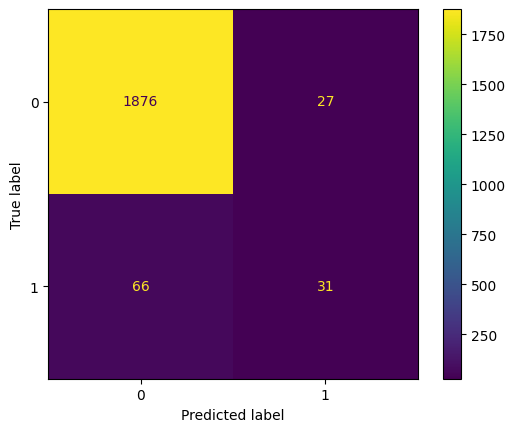

🏃 View run resilient-shrew-351 at: http://localhost:5000/#/experiments/811932844240729824/runs/0fd416015ebd4eeb88215715db76e761
🧪 View experiment at: http://localhost:5000/#/experiments/811932844240729824


In [40]:
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("Spotify popular song prediction")
mlflow.autolog()

numeric = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
# numeric = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'no_of_songs', 'popular_song_percentage']
categorical = ['year', 'genre', 'key', 'time_signature']

X = spotify[numeric + categorical]
y = spotify['is_popular']

X, _, y, _ = train_test_split(X, y, train_size=10000, random_state=RAND, shuffle=True)

# print(X.dtypes)

# LogisticRegression
# model = RandomForestClassifier()
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')


with mlflow.start_run() as run:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND)

    model_name, pipefinal = make_Pipeline(model)

    pipefinal.fit(X_train, y_train)

    y_pred = pipefinal.predict(X_test)








    best_pipeline = pipefinal.best_estimator_
    best_model = best_pipeline.named_steps['model']
    preprocessor = best_pipeline.named_steps['col_transformer']


    feature_names = preprocessor.get_feature_names_out()
    # Transform the test data for SHAP
    X_test_transformed = preprocessor.transform(X_test)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

    # SHAP explainer
    explainer = shap.Explainer(best_model, X_test_transformed_df)
    shap_values = explainer(X_test_transformed_df)

    # Log SHAP summary
    shap.summary_plot(shap_values, X_test_transformed_df, show=False)
    plt.savefig("plots/shap_summary.png")
    mlflow.log_artifact("plots/shap_summary.png")
    plt.close()

    # Waterfall plot for first "hit"
    hit_indices = (y_pred == 1).nonzero()[0][:5]
    for i, idx in enumerate(hit_indices):
        shap.plots.waterfall(shap_values[idx], show=False)
        plt.gcf().set_size_inches(24, 8)
        filename = f"plots/shap_waterfall_hit_{i}.png"
        plt.savefig(filename)
        mlflow.log_artifact(filename)
        plt.close()

    # Waterfall plot for first "miss"
    miss_indices = (y_pred == 0).nonzero()[0][:5]
    for i, idx in enumerate(miss_indices):
        shap.plots.waterfall(shap_values[idx], show=False)
        plt.gcf().set_size_inches(24, 8)
        filename = f"plots/shap_waterfall_miss_{i}.png"
        plt.savefig(filename)
        mlflow.log_artifact(filename)
        plt.close()







    accuracy_value = accuracy_score(y_test, y_pred)
    precision_value = precision_score(y_test, y_pred)
    recall_value = recall_score(y_test, y_pred)
    f1_value = f1_score(y_test, y_pred)
    confusion_mx = confusion_matrix(y_test, y_pred)

    mlflow.log_param("best_params_", pipefinal.best_params_)
    mlflow.log_metric("best_score_", pipefinal.best_score_)

    mlflow.log_metric("TEST_accuracy", accuracy_value)
    mlflow.log_metric("TEST_precision", precision_value)
    mlflow.log_metric("TEST_recall", recall_value)
    mlflow.log_metric("TEST_f1", f1_value)

    np.savetxt("plots/confusion_matrix.csv", confusion_mx, delimiter=",", fmt="%d")
    mlflow.log_artifact("plots/confusion_matrix.csv")

    mlflow.sklearn.log_model(pipefinal, "model", input_example=X_test[:5], registered_model_name="SHAP_Spotify_NO_ARTISTS")

    
    
    model_uri = f"runs:/{run.info.run_id}/model"
    
    eval_data = X_test.copy()
    eval_data['target'] = y_test
    
    results = mlflow.evaluate(
        model=model_uri,
        data=eval_data,
        targets='target',
        model_type='classifier',
    )


    print("best_params_:", pipefinal.best_params_)
    print("best_score_: ", pipefinal.best_score_)
    print("Accuracy:    ", accuracy_value)
    print("Precision:   ", precision_value)
    print("Recall:      ", recall_value)
    print("F1 Score:    ", f1_value)
    print("Confusion Matrix:\n", confusion_mx)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mx)
    disp.plot()
    plt.show()

# pipeline

In [ ]:
def make_Pipeline(model):

    if isinstance(model, RandomForestClassifier):
        model_name = 'RandomForestClassifier'
        param_grid = {
            'randomforestclassifier__class_weight': ['balanced'],
            'randomforestclassifier__n_estimators': [400],
            'randomforestclassifier__max_depth': [10],
            # 'randomforestclassifier__min_samples_split': [2, 5, 10],
            # 'randomforestclassifier__min_samples_leaf': [1, 2, 4],
            # 'randomforestclassifier__max_features': [0.75],
            # 'randomforestclassifier__max_features': [0.7, 0.75, 0.8],
        }
    elif isinstance(model, XGBClassifier):
        model_name = 'XGBClassifier'
        param_grid = {
            # dont_overestimate
            'model__n_estimators': [2000],
            'model__max_depth': [5],
            'model__learning_rate': [0.05],
            'model__subsample': [1.0],
            'model__colsample_bytree': [0.4],
            'model__reg_lambda': [1.0],
            'model__scale_pos_weight': [2],
            # dont_miss_hits
            # 'model__n_estimators': [3500],
            # 'model__max_depth': [3],
            # 'model__learning_rate': [0.02],
            # 'model__subsample': [0.8],
            # 'model__colsample_bytree': [0.4],
            # 'model__reg_lambda': [1.0],
            # 'model__scale_pos_weight': [28],
        }


    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler()),
    ])

    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scale', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ])

    col_transformer = ColumnTransformer(transformers=[
        ('num_pipe', num_pipe, numeric),
        ('cat_pipe', cat_pipe, categorical),
    ],
        remainder='drop',
        n_jobs=-1,
        verbose=2,
    )

    combined_pipe = Pipeline([
            ('col_transformer', col_transformer),
            ('model', model),
        ])

    return model_name, GridSearchCV(combined_pipe, param_grid, cv=2, scoring='f1')

    # return model_name, RandomizedSearchCV(
    #     combined_pipe, param_distributions=param_grid, n_iter=2,
    #     scoring='f1',
    #     cv=2, verbose=1, random_state=RAND
    # )
    